In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from functools import reduce
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

plt.rcParams["font.family"] = "Malgun Gothic"  

In [2]:
data_path = r"C:\Users\james\J_Data_Lab\Project-FXCast\data"

# 파일명 목록
file_names = [
    
    # 환율
    "USD_KRW_2020.01.01~2024.12.31.csv",

    # 국내 주식시장
    "KOSPI_2020.01.01~2024.12.31.csv",
    "KOSDAQ_2020.01.01~2024.12.31.csv",

    # 미국 주식시장
    "DJI_2020.01.01~2024.12.31.csv",
    "SP500_2020.01.01~2024.12.31.csv",

    # 원자재 시장
    "WTI_USD_2020.01.01~2024.12.31.csv", #원유
    "XAU_USD_2020.01.01~2024.12.31.csv", #금

    # 한국 통화 공급 지표(M1, M2)
    #"money_supply_index_M1_2020.01.01~2024.12.31.csv",
    #"money_supply_index_M2_2020.01.01~2024.12.31.csv",

    # 한국 소비자 물가 지수 & 생산자 물가 지수
    #"korea_cpi_2020.01.01~2024.12.31.csv",
    #"korea_ppi_2020.01.01~2024.12.31.csv",

    # 한국 경상수지 & 무역수지
    #"korea_balance__2020.01.01~2024.12.31.csv",

    # 한미 정책 금리
    #"kr_usa_funds_rate_2020.01.01~2024.12.31.csv"

]

In [3]:
# 데이터 불러오기
dataframes = {}
for file in file_names:
    file_path = os.path.join(data_path, file)
    try:
        df = pd.read_csv(file_path, encoding="utf-8")
        
        # 날짜 컬럼명, date 변환
        if "Date" in df.columns:
            df.rename(columns={'Date': 'date'}, inplace=True)
        elif "날짜" in df.columns:
            df.rename(columns={'날짜': 'date'}, inplace=True)
        
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

        dataframes[file.split(".csv")[0]] = df
        print(f"{file} 불러오기 완료! shape: {df.shape}")
    except Exception as e:
        print(f"{file} 불러오기 실패: {e}")

# 데이터프레임 확인
for name, df in dataframes.items():
    print(f"\n==== {name} ====")
    print(df.head())

USD_KRW_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1305, 7)
KOSPI_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1232, 7)
KOSDAQ_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1231, 7)
DJI_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1259, 7)
SP500_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1258, 7)
WTI_USD_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1543, 7)
XAU_USD_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1302, 7)

==== USD_KRW_2020.01.01~2024.12.31 ====
        date        종가        시가        고가        저가  거래량    변동 %
0 2024-12-31  1,476.78  1,472.08  1,479.69  1,469.84  NaN   0.51%
1 2024-12-30  1,469.25  1,471.10  1,477.08  1,466.20  NaN  -0.22%
2 2024-12-27  1,472.50  1,468.40  1,487.37  1,466.20  NaN   0.37%
3 2024-12-26  1,467.08  1,457.21  1,471.27  1,456.63  NaN   0.73%
4 2024-12-25  1,456.52  1,460.93  1,460.93  1,455.51  NaN  -0.17%

==== KOSPI_2020.01.01~2024.12.31 ====
        date        종가        시가        고가        저가      거래량    변동 %
0 2024-12-30  2,399.49  2,397.49  2,429.75 

In [4]:
# 변수 선택
df_investing = dataframes["USD_KRW_2020.01.01~2024.12.31"][["date", "종가", "시가"]].rename(
    columns={"종가": "USD_KRW 종가", "시가": "USD_KRW 시가"}
)

for name, cols in [
    ("KOSPI_2020.01.01~2024.12.31", ["종가", "거래량"]),
    ("KOSDAQ_2020.01.01~2024.12.31", ["종가", "거래량"]),
    ("WTI_USD_2020.01.01~2024.12.31", ["Price"]),
    ("XAU_USD_2020.01.01~2024.12.31", ["Price"]),
    ("DJI_2020.01.01~2024.12.31", ["종가", "거래량"]),
    ("SP500_2020.01.01~2024.12.31", ["종가"])
]:
    df_temp = dataframes[name][["date"] + cols].rename(
        columns={col: f"{name.split('_')[0]} {col}" for col in cols}
    )
    df_investing = df_investing.merge(df_temp, on="date", how="inner")

# 데이터 확인
print(df_investing.shape)
df_investing

(1186, 12)


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가
0,2024-12-30,"1,469.25","1,471.10","2,399.49",303.96M,678.19,644.55M,70.99,"2,605.39","42,573.73",383.30M,"5,906.94"
1,2024-12-27,"1,472.50","1,468.40","2,404.77",311.29M,665.97,814.13M,70.08,"2,620.00","42,992.21",376.96M,"5,970.84"
2,2024-12-26,"1,467.08","1,457.21","2,429.67",322.80M,675.64,829.29M,69.53,"2,634.43","43,325.80",270.36M,"6,037.59"
3,2024-12-24,"1,458.93","1,453.28","2,440.52",386.78M,680.11,645.10M,69.92,"2,613.20","43,297.03",230.41M,"6,040.04"
4,2024-12-23,"1,451.28","1,446.05","2,442.01",428.17M,679.24,657.71M,69.34,"2,612.93","42,906.95",449.40M,"5,974.07"
...,...,...,...,...,...,...,...,...,...,...,...,...
1181,2020-01-08,"1,162.25","1,168.30","2,151.31",913.83M,640.94,1.38B,59.97,"1,555.81","28,745.09",296.43M,"3,253.10"
1182,2020-01-07,"1,167.30","1,167.54","2,175.54",568.24M,663.44,970.31M,64.92,"1,573.99","28,583.68",266.68M,"3,237.20"
1183,2020-01-06,"1,166.94","1,165.89","2,155.07",592.67M,655.31,884.28M,62.99,"1,565.96","28,703.38",261.81M,"3,246.30"
1184,2020-01-03,"1,164.95","1,157.95","2,176.46",631.56M,669.93,903.86M,63.10,"1,551.65","28,634.88",239.59M,"3,234.80"


In [5]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())
    
    print("\nInfo:")
    print(df.info())
    
    print("\nDescribe (numeric):")
    display(df.describe())
    
    print("\nNull counts:")
    print(df.isnull().sum())
    
    print("="*40)

In [6]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가
0,2024-12-30,"1,469.25","1,471.10","2,399.49",303.96M,678.19,644.55M,70.99,"2,605.39","42,573.73",383.30M,"5,906.94"
1,2024-12-27,"1,472.50","1,468.40","2,404.77",311.29M,665.97,814.13M,70.08,"2,620.00","42,992.21",376.96M,"5,970.84"
2,2024-12-26,"1,467.08","1,457.21","2,429.67",322.80M,675.64,829.29M,69.53,"2,634.43","43,325.80",270.36M,"6,037.59"
3,2024-12-24,"1,458.93","1,453.28","2,440.52",386.78M,680.11,645.10M,69.92,"2,613.20","43,297.03",230.41M,"6,040.04"
4,2024-12-23,"1,451.28","1,446.05","2,442.01",428.17M,679.24,657.71M,69.34,"2,612.93","42,906.95",449.40M,"5,974.07"



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   object        
 2   USD_KRW 시가  1186 non-null   object        
 3   KOSPI 종가    1186 non-null   object        
 4   KOSPI 거래량   1186 non-null   object        
 5   KOSDAQ 종가   1186 non-null   object        
 6   KOSDAQ 거래량  1186 non-null   object        
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   object        
 9   DJI 종가      1186 non-null   object        
 10  DJI 거래량     1186 non-null   object        
 11  SP500 종가    1186 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 111.3+ KB
None

Describe (numeric):


,date,WTI Price
count,1186,1186.000000
mean,2022-06-25 11:34:30.151770624,69.533440
min,2020-01-02 00:00:00,7.790000
25%,2021-03-29 06:00:00,62.090000
50%,2022-06-25 12:00:00,73.735000
75%,2023-09-18 18:00:00,82.030000
max,2024-12-30 00:00:00,126.470000
std,NaN,23.291945



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
dtype: int64


In [7]:
def convert_units(value):
    if isinstance(value, str):
        value = value.replace(",", "").strip()  
        if value.endswith("K"):  
            return float(value[:-1]) * 1_000  
        elif value.endswith("M"):  
            return float(value[:-1]) * 1_000_000  
        elif value.endswith("B"):  
            return float(value[:-1]) * 1_000_000_000 
        else:
            return float(value)  
    return value

# object 타입 변환
for col in df_investing.columns:
    if col != "date" and df_investing[col].dtype == 'object':
        df_investing[col] = df_investing[col].apply(convert_units)

print(df_investing.info())
print(df_investing.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 111.3 KB
None
        date  USD_KRW 종가  USD_KRW 시가  KOSPI 종가    KOSPI 거래량  KOSDAQ 종가  \
0 2024-12-30     1469.25     1471.10   2399.49  303960000.0     678.19   
1 2024

In [8]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 111.3 KB
None

Describe (numeric):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
dtype: int64


In [9]:
data_path = r"C:\Users\james\J_Data_Lab\Project-FXCast\data"

# 파일명 목록
file_names = [
    
    # 한국 통화 공급 지표(M1, M2)
    "money_supply_index_M1_2020.01.01~2024.12.31.csv",
    "money_supply_index_M2_2020.01.01~2024.12.31.csv",

    # 한국 소비자 물가 지수 & 생산자 물가 지수
    "korea_cpi_2020.01.01~2024.12.31.csv",
    "korea_ppi_2020.01.01~2024.12.31.csv",

    # 한국 경상수지 & 무역수지
    "korea_balance__2020.01.01~2024.12.31.csv",

    # 한미 정책 금리
    "kr_usa_funds_rate_2020.01.01~2024.12.31.csv"

]

In [10]:
dataframes = {}
for file in file_names:
    file_path = os.path.join(data_path, file)
    try:
        df = pd.read_csv(file_path, encoding="utf-8")  
        dataframes[file.split(".csv")[0]] = df
        print(f"{file} 불러오기 완료! shape: {df.shape}")
    except Exception as e:
        print(f"{file} 불러오기 실패: {e}")

# 데이터프레임 확인
for name, df in dataframes.items():
    print(f"\n==== {name} ====")
    print(df.head())

money_supply_index_M1_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (60, 3)
money_supply_index_M2_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (60, 3)
korea_cpi_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (8, 61)
korea_ppi_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (1, 61)
korea_balance__2020.01.01~2024.12.31.csv 불러오기 완료! shape: (6, 61)
kr_usa_funds_rate_2020.01.01~2024.12.31.csv 불러오기 완료! shape: (5479, 3)

==== money_supply_index_M1_2020.01.01~2024.12.31 ====
        기간         M1  증가율
0  2020-01   944.3064  1.7
1  2020-02   967.1926  2.4
2  2020-03   986.3261  2.0
3  2020-04  1005.4722  1.9
4  2020-05  1032.4776  2.7

==== money_supply_index_M2_2020.01.01~2024.12.31 ====
        기간         M2  증가율
0  2020-01  2935.6403  0.7
1  2020-02  2951.0403  0.5
2  2020-03  2982.4281  1.1
3  2020-04  3014.8155  1.1
4  2020-05  3048.9437  1.1

==== korea_cpi_2020.01.01~2024.12.31 ====
  Unnamed: 0  202001월  202002월  202003월  202004월  202005월  202006월  202007월  \
0      소비자물가      1.2      0.9      0.8      

In [11]:
# '월' 컬럼 추가 (YYYY-MM 형식)
df_investing["month"] = df_investing["date"].dt.strftime("%Y-%m")

# 각 경제 지표 데이터의 '기간'을 'month'로 변환
for name, df in dataframes.items():
    if "기간" in df.columns:
        df.rename(columns={"기간": "month"}, inplace=True)

# 필요한 데이터만 병합 (left join)
merge_targets = [
    ("money_supply_index_M1_2020.01.01~2024.12.31", ["M1"]),
    ("money_supply_index_M2_2020.01.01~2024.12.31", ["M2"]),
]

for dataset_name, columns in merge_targets:
    df_to_merge = dataframes[dataset_name][["month"] + columns]
    df_investing = df_investing.merge(df_to_merge, on="month", how="left")

# 'month' 컬럼 제거 (불필요한 경우)
df_investing.drop(columns=["month"], inplace=True)

In [12]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
 12  M1          1186 non-null   float64       
 13  M2          1186 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 129.8 KB
None

Describe (numeric):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
dtype: int64


In [18]:
# '기간'을 datetime으로 변환 후 'month' 추출
df_funds_rate = dataframes["kr_usa_funds_rate_2020.01.01~2024.12.31"]
df_funds_rate["month"] = pd.to_datetime(df_funds_rate["month"])
df_funds_rate["month"] = df_funds_rate["month"].dt.strftime("%Y-%m")

# 월별 평균 금리 계산 (각 월의 금리 평균값 사용)
df_funds_rate_monthly = df_funds_rate.groupby("month")[["한국 정책금리", "미국 정책금리"]].mean().reset_index()

# 기존 데이터프레임과 병합 (left join)
df_investing["month"] = df_investing["date"].dt.strftime("%Y-%m")
df_investing = df_investing.merge(df_funds_rate_monthly, on="month", how="left")

# 불필요한 'month' 컬럼 제거
df_investing.drop(columns=["month"], inplace=True)

In [19]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
 12  M1          1186 non-null   float64       
 13  M2          1186 non-null   float64       
 14  한국 정책금리     1186 non-null   float64       
 15  미국 정책금리     1186 non-null   float64       
dtypes: datetime64[ns]

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
한국 정책금리       0
미국 정책금리       0
dtype: int64


In [20]:
# CPI 데이터 가져오기
df_cpi = dataframes["korea_cpi_2020.01.01~2024.12.31"]

# "소비자물가" 행만 선택
df_cpi = df_cpi[df_cpi["Unnamed: 0"] == "소비자물가"]

# 열 이름을 'month' 형식으로 변환
df_cpi = df_cpi.drop(columns=["Unnamed: 0"]).T.reset_index()
df_cpi.columns = ["month", "CPI"]
df_cpi["month"] = df_cpi["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[0] + "-" + df_cpi["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[1]

# df_investing과 병합
df_investing["month"] = df_investing["date"].dt.strftime("%Y-%m")
df_investing = df_investing.merge(df_cpi, on="month", how="left")

In [21]:
# PPI 데이터 가져오기
df_ppi = dataframes["korea_ppi_2020.01.01~2024.12.31"]

# "생산자물가지수" 행만 선택
df_ppi = df_ppi[df_ppi["Unnamed: 0"] == "생산자물가지수"]

# 열 이름을 'month' 형식으로 변환
df_ppi = df_ppi.drop(columns=["Unnamed: 0"]).T.reset_index()
df_ppi.columns = ["month", "PPI"]
df_ppi["month"] = df_ppi["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[0] + "-" + df_ppi["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[1]

# df_investing과 병합
df_investing = df_investing.merge(df_ppi, on="month", how="left")

In [22]:
# 경상수지 데이터 가져오기
df_balance = dataframes["korea_balance__2020.01.01~2024.12.31"]

# "경상수지" 행만 선택
df_balance = df_balance[df_balance["Unnamed: 0"] == "경상수지"]

# 열 이름을 'month' 형식으로 변환
df_balance = df_balance.drop(columns=["Unnamed: 0"]).T.reset_index()
df_balance.columns = ["month", "경상수지"]
df_balance["month"] = df_balance["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[0] + "-" + df_balance["month"].str.extract(r"(\d{4})[.\-]?(\d{2})")[1]

# df_investing과 병합
df_investing = df_investing.merge(df_balance, on="month", how="left")

In [23]:
# 불필요한 'month' 컬럼 제거
df_investing.drop(columns=["month"], inplace=True)

In [24]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,"12,368"
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,"12,368"
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,"12,368"
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,"12,368"
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,"12,368"



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
 12  M1          1186 non-null   float64       
 13  M2          1186 non-null   float64       
 14  한국 정책금리     1186 non-null   float64       
 15  미국 정책금리     1186 non-null   float64       
 16  CPI         1186 

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
한국 정책금리       0
미국 정책금리       0
CPI           0
PPI           0
경상수지          0
dtype: int64


In [25]:
# 쉼표 제거 후 float 변환 
df_investing["경상수지"] = df_investing["경상수지"].astype(str).str.replace(",", "").astype(float)

# 변환 후 데이터 타입 확인
print(df_investing[["경상수지"]].info())
print(df_investing.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   경상수지    1186 non-null   float64
dtypes: float64(1)
memory usage: 9.4 KB
None
        date  USD_KRW 종가  USD_KRW 시가  KOSPI 종가    KOSPI 거래량  KOSDAQ 종가  \
0 2024-12-30     1469.25     1471.10   2399.49  303960000.0     678.19   
1 2024-12-27     1472.50     1468.40   2404.77  311290000.0     665.97   
2 2024-12-26     1467.08     1457.21   2429.67  322800000.0     675.64   
3 2024-12-24     1458.93     1453.28   2440.52  386780000.0     680.11   
4 2024-12-23     1451.28     1446.05   2442.01  428170000.0     679.24   

    KOSDAQ 거래량  WTI Price  XAU Price    DJI 종가      DJI 거래량  SP500 종가  \
0  644550000.0      70.99    2605.39  42573.73  383300000.0   5906.94   
1  814130000.0      70.08    2620.00  42992.21  376960000.0   5970.84   
2  829290000.0      69.53    2634.43  43325.80  270360000.0   6037.59   
3

In [26]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1186 non-null   datetime64[ns]
 1   USD_KRW 종가  1186 non-null   float64       
 2   USD_KRW 시가  1186 non-null   float64       
 3   KOSPI 종가    1186 non-null   float64       
 4   KOSPI 거래량   1186 non-null   float64       
 5   KOSDAQ 종가   1186 non-null   float64       
 6   KOSDAQ 거래량  1186 non-null   float64       
 7   WTI Price   1186 non-null   float64       
 8   XAU Price   1186 non-null   float64       
 9   DJI 종가      1186 non-null   float64       
 10  DJI 거래량     1186 non-null   float64       
 11  SP500 종가    1186 non-null   float64       
 12  M1          1186 non-null   float64       
 13  M2          1186 non-null   float64       
 14  한국 정책금리     1186 non-null   float64       
 15  미국 정책금리     1186 non-null   float64       
 16  CPI         1186 

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
한국 정책금리       0
미국 정책금리       0
CPI           0
PPI           0
경상수지          0
dtype: int64


In [27]:
# csv 저장
df_investing.to_csv(os.path.join(data_path, "df_investing2.csv"), index=False, encoding="utf-8-sig")

In [31]:
# `USD_KRW 종가`의 lag 변수 추가 (d-1 ~ d-5)
for i in range(1, 6):
    df_investing[f"USD_KRW 종가_d-{i}"] = df_investing["USD_KRW 종가"].shift(i)

# 결측치 처리 
df_investing.dropna(inplace=True)  

<class 'pandas.core.frame.DataFrame'>
Index: 1181 entries, 5 to 1185
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1181 non-null   datetime64[ns]
 1   USD_KRW 종가      1181 non-null   float64       
 2   USD_KRW 시가      1181 non-null   float64       
 3   KOSPI 종가        1181 non-null   float64       
 4   KOSPI 거래량       1181 non-null   float64       
 5   KOSDAQ 종가       1181 non-null   float64       
 6   KOSDAQ 거래량      1181 non-null   float64       
 7   WTI Price       1181 non-null   float64       
 8   XAU Price       1181 non-null   float64       
 9   DJI 종가          1181 non-null   float64       
 10  DJI 거래량         1181 non-null   float64       
 11  SP500 종가        1181 non-null   float64       
 12  M1              1181 non-null   float64       
 13  M2              1181 non-null   float64       
 14  한국 정책금리         1181 non-null   float64       
 15  미국 정책금리  

In [39]:
# 이동 평균 (Moving Average)
df_investing["USD_KRW 종가_MA5"] = df_investing["USD_KRW 종가"].rolling(window=5).mean()
df_investing["USD_KRW 종가_MA10"] = df_investing["USD_KRW 종가"].rolling(window=10).mean()

# 변동률 (Rate of Change)
df_investing["USD_KRW 종가_ROC5"] = df_investing["USD_KRW 종가"].pct_change(periods=5)

# 차분 (Differencing)
df_investing["USD_KRW 종가_diff1"] = df_investing["USD_KRW 종가"].diff(1)
df_investing["USD_KRW 종가_diff5"] = df_investing["USD_KRW 종가"].diff(5)

# 결측치 제거
df_investing.dropna(inplace=True)

In [40]:
eda_basic_info(df_investing, "df_investing")


===== df_investing =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,USD_KRW 종가_d-1,USD_KRW 종가_d-2,USD_KRW 종가_d-3,USD_KRW 종가_d-4,USD_KRW 종가_d-5,USD_KRW 종가_MA5,USD_KRW 종가_MA10,USD_KRW 종가_ROC5,USD_KRW 종가_diff1,USD_KRW 종가_diff5
9,2020-01-23,1168.54,1165.76,2246.13,509610000.0,685.57,9.577800e+08,55.62,1563.33,29160.09,...,1164.76,1169.01,1160.44,1159.73,1157.91,1164.496,1160.823,0.009180,3.78,10.63
10,2020-01-28,1175.71,1177.70,2176.72,808880000.0,664.70,1.160000e+09,53.74,1566.24,28722.85,...,1168.54,1164.76,1169.01,1160.44,1159.73,1167.692,1162.522,0.013779,7.17,15.98
11,2020-01-29,1178.68,1176.21,2185.28,692300000.0,670.18,1.060000e+09,53.09,1577.12,28734.45,...,1175.71,1168.54,1164.76,1169.01,1160.44,1171.340,1164.593,0.015718,2.97,18.24
12,2020-01-30,1187.64,1179.68,2148.00,602840000.0,656.39,1.210000e+09,52.84,1574.22,28859.44,...,1178.68,1175.71,1168.54,1164.76,1169.01,1175.066,1167.962,0.015937,8.96,18.63
13,2020-01-31,1194.97,1188.64,2119.01,710510000.0,642.48,1.340000e+09,51.57,1590.20,28256.03,...,1187.64,1178.68,1175.71,1168.54,1164.76,1181.108,1171.739,0.025937,7.33,30.21



Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 9 to 1180
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1172 non-null   datetime64[ns]
 1   USD_KRW 종가        1172 non-null   float64       
 2   USD_KRW 시가        1172 non-null   float64       
 3   KOSPI 종가          1172 non-null   float64       
 4   KOSPI 거래량         1172 non-null   float64       
 5   KOSDAQ 종가         1172 non-null   float64       
 6   KOSDAQ 거래량        1172 non-null   float64       
 7   WTI Price         1172 non-null   float64       
 8   XAU Price         1172 non-null   float64       
 9   DJI 종가            1172 non-null   float64       
 10  DJI 거래량           1172 non-null   float64       
 11  SP500 종가          1172 non-null   float64       
 12  M1                1172 non-null   float64       
 13  M2                1172 non-null   float64       
 14  한국 정책금리           1172

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,USD_KRW 종가_d-1,USD_KRW 종가_d-2,USD_KRW 종가_d-3,USD_KRW 종가_d-4,USD_KRW 종가_d-5,USD_KRW 종가_MA5,USD_KRW 종가_MA10,USD_KRW 종가_ROC5,USD_KRW 종가_diff1,USD_KRW 종가_diff5
count,1172,1172.000000,1172.000000,1172.000000,1.172000e+03,1172.000000,1.172000e+03,1172.000000,1172.000000,1172.000000,...,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,2022-07-06 04:24:09.829351680,1257.417338,1257.771971,2600.692858,7.138336e+08,843.170947,1.310225e+09,69.649923,1942.084906,33658.789343,...,1257.157534,1256.898584,1256.636945,1256.381655,1256.131340,1256.898411,1256.268346,0.001060,0.259804,1.285998
min,2020-01-23 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,...,1083.530000,1083.530000,1083.530000,1083.530000,1083.530000,1084.838000,1088.280000,-0.063850,-39.290000,-89.600000
25%,2021-04-13 18:00:00,1183.480000,1184.335000,2403.720000,4.616975e+08,765.032500,9.576875e+08,63.427500,1781.575000,31103.220000,...,1183.415000,1183.357500,1183.147500,1182.852500,1182.707500,1184.350000,1183.857750,-0.006140,-4.040000,-7.632500
50%,2022-07-06 12:00:00,1267.605000,1268.670000,2571.290000,6.141600e+08,849.720000,1.170000e+09,73.920000,1871.500000,33946.905000,...,1267.480000,1267.195000,1266.835000,1266.615000,1266.455000,1267.356000,1267.738500,0.000831,0.490000,1.075000
75%,2023-09-22 18:00:00,1333.265000,1333.645000,2762.527500,8.690175e+08,921.732500,1.500000e+09,82.115000,1988.670000,35722.192500,...,1333.157500,1333.062500,1333.040000,1332.980000,1332.930000,1331.809000,1331.430750,0.008676,4.622500,10.392500
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,...,1472.500000,1467.080000,1458.930000,1452.700000,1452.700000,1463.808000,1453.503000,0.053573,24.910000,63.890000
std,NaN,93.720433,93.760401,338.618977,3.572851e+08,113.603460,5.225204e+08,23.404801,261.797827,4657.374844,...,93.554601,93.377893,93.217932,93.073039,92.942832,93.170431,92.602487,0.012335,7.273671,15.805696



Null counts:
date                0
USD_KRW 종가          0
USD_KRW 시가          0
KOSPI 종가            0
KOSPI 거래량           0
KOSDAQ 종가           0
KOSDAQ 거래량          0
WTI Price           0
XAU Price           0
DJI 종가              0
DJI 거래량             0
SP500 종가            0
M1                  0
M2                  0
한국 정책금리             0
미국 정책금리             0
CPI                 0
PPI                 0
경상수지                0
USD_KRW 종가_d-1      0
USD_KRW 종가_d-2      0
USD_KRW 종가_d-3      0
USD_KRW 종가_d-4      0
USD_KRW 종가_d-5      0
USD_KRW 종가_MA5      0
USD_KRW 종가_MA10     0
USD_KRW 종가_ROC5     0
USD_KRW 종가_diff1    0
USD_KRW 종가_diff5    0
dtype: int64


In [42]:
# 날짜 기준 정렬 
df_investing = df_investing.sort_values(by="date").reset_index(drop=True)

# 학습 / 테스트 데이터 분할 기준 날짜 설정 (80% 학습, 20% 테스트)
split_index = int(len(df_investing) * 0.8)

# 훈련(Train) 및 테스트(Test) 데이터 분할
train_data = df_investing.iloc[:split_index]
test_data = df_investing.iloc[split_index:]

# 독립변수(X), 종속변수(y) 설정
target_col = "USD_KRW 종가"
features = [col for col in df_investing.columns if col != "date"  and col != target_col]
# and col != "USD_KRW 시가"

X_train, y_train = train_data[features].values, train_data[target_col].values
X_test, y_test = test_data[features].values, test_data[target_col].values

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# 시계열 데이터 형식으로 변환 
timesteps = 30  # 과거 30일 데이터를 기반으로 예측
X_train_seq, y_train_seq, X_test_seq, y_test_seq = [], [], [], []

# 훈련 데이터 변환
for i in range(len(X_train_scaled) - timesteps):
    X_train_seq.append(X_train_scaled[i:i + timesteps])
    y_train_seq.append(y_train_scaled[i + timesteps])

# 테스트 데이터 변환
for i in range(len(X_test_scaled) - timesteps):
    X_test_seq.append(X_test_scaled[i:i + timesteps])
    y_test_seq.append(y_test_scaled[i + timesteps])

X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# 날짜 기반 테스트 데이터 저장
dates_test = test_data["date"].iloc[timesteps:].reset_index(drop=True)

print(f"X_train_seq.shape: {X_train_seq.shape}, X_test_seq.shape: {X_test_seq.shape}")
print(f"y_train_seq.shape: {y_train_seq.shape}, y_test_seq.shape: {y_test_seq.shape}")

X_train_seq.shape: (907, 30, 27), X_test_seq.shape: (205, 30, 27)
y_train_seq.shape: (907, 1), y_test_seq.shape: (205, 1)


In [47]:
# LSTM 모델 정의
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# 모델 학습
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

Epoch 1/50


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1332 - val_loss: 0.0484
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0509
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0360
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0321
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0314
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045 - val_loss: 0.0332
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0253
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0321
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - val_loss: 0.0277
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0187
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MSE: 3849.1665
RMSE: 62.0417
MAPE: 4.24%


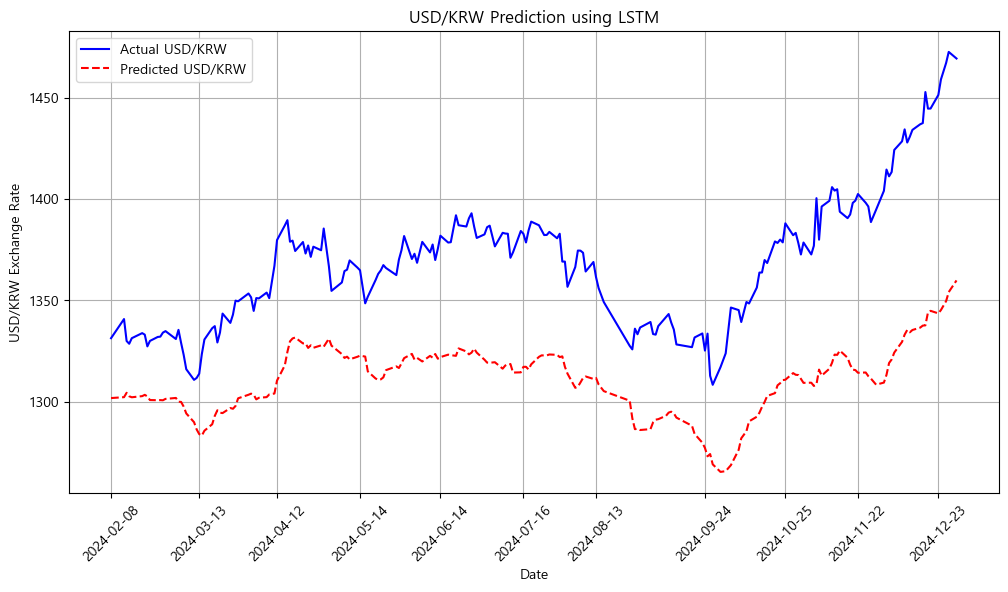

In [48]:
# 예측 수행
y_pred_scaled = model.predict(X_test_seq)

# 스케일 복원 
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_seq)

mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100 

# 평가 결과 출력
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


# 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_real, label="Actual USD/KRW", color="blue")
plt.plot(dates_test, y_pred, label="Predicted USD/KRW", color="red", linestyle="dashed")

plt.xticks(ticks=dates_test[::int(len(dates_test)/10)], rotation=45) 
plt.xlabel("Date")
plt.ylabel("USD/KRW Exchange Rate")
plt.title("USD/KRW Prediction using LSTM")
plt.legend()
plt.grid()

plt.show()